In [1]:
import torch 
import math
import matplotlib.pyplot as plt

In [17]:
# True Solution
x = torch.linspace(-math.pi, math.pi, 2000)
y = torch.sin(x)

p = torch.tensor([1, 2, 3]) # Polynomial order
xx = x.unsqueeze(-1).pow(p) # X vals before weights

model = torch.nn.Sequential(
    torch.nn.Linear(3, 1), # Weights for order p?
    torch.nn.Flatten(0, 1) # Bias? 
)
loss_fn = torch.nn.MSELoss(reduction='sum')

In [18]:
learning_rate = 1e-03
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
for t in range(2000):
    y_pred = model(xx)
    
    loss = loss_fn(y_pred, y)
    if t % 100 == 99: 
        print(t, loss.item())
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

linear_layer = model[0]
print(f'Result: y = {linear_layer.bias.item()} + {linear_layer.weight[:, 0].item()} x + {linear_layer.weight[:, 1].item()} xx^2 + {linear_layer.weight[:, 2].item()} x^3')

99 26398.03515625
199 13240.33984375
299 6272.4228515625
399 2966.531005859375
499 1583.7598876953125
599 1067.915283203125
699 883.7062377929688
799 808.4307250976562
899 765.3545532226562
999 731.8778686523438
1099 701.7838134765625
1199 673.1152954101562
1299 645.0240478515625
1399 617.0621948242188
1499 589.005126953125
1599 560.773193359375
1699 532.3801879882812
1799 503.89593505859375
1899 475.4210205078125
1999 447.0714111328125
Result: y = -0.0017966125160455704 + 0.21281208097934723 x + 0.0003524300118442625 xx^2 + -0.000163135991897434 x^3


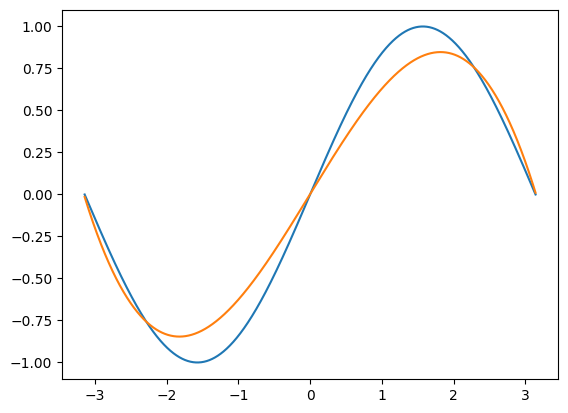

In [14]:
plt.figure()
plt.plot(x, y)
plt.plot(x, y_pred.data.numpy())
plt.show()